In [13]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms

In [14]:
print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


In [15]:
# 学習済みを利用
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# 推論モード
net.eval()

print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# 前処理
class BaseTransform():

    """
    resize:int
    リサイズ先の画像の大きさ
    mean:(R, G, B)
    各色チャネルの平均値
    std:(R, G, B)
    各色チャネルの標準偏差
    """
    
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize), # 短辺の長さがresizeの大きさ
            transforms.CenterCrop(resize), # 画像中央をresize * resizeで切り取り 
            transforms.ToTensor(), # Torchテンソルに変換
            transforms.Normalize(mean, std) # 色情報の標準化
        ])
        
    def __call__(self, img):
        return self.base_transform(img)

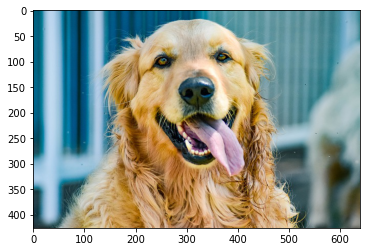

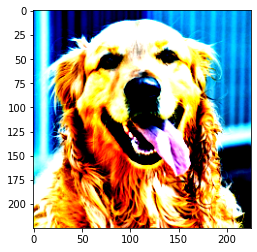

In [17]:
# 前処理テスト

image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

resize = 225
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)

# (colog, h, w)を(h, w, color)に変換する
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# 0 ~ 1に変換
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [18]:
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [20]:
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める
    
    Attributes
    
    class_index dictionary
        クラスindexとラベル名を対応させた辞書型変数
    """
    
    def __init__(self, class_index):
        self.class_index = class_index
        
    def predict_max(self, out):
        """
        Parameters
        
        out torch.Size([1, 1000])
            Netからの出力
            
        Returns
        
        predicted_label_name str
            最も予測確率が高いラベルの名前
        """
        
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        
        return predicted_label_name

In [21]:
# ILSVRCのラベル情報をロード．辞書型変数を定義
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredectorのインスタンスを生成
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 入力画像のload
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [h][w][rgb]

# 前処理のあと，バッチサイズの次元を追加
transform = BaseTransform(resize, mean, std) # 前処理クラス作成
img_transformed = transform(img) # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0) # torch.Size([1, 3, 224, 224])

# モデルに入力し，モデル出力をラベルに変換する
out = net(inputs) # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 予測結果を入力する
print("入力画像の予測結果 : ", result)

入力画像の予測結果 :  golden_retriever
